# OFTI Introduction

by Isabel Angelo (2018)

OFTI (Orbits For The Impatient) is an orbit-generating algorithm designed specifically to handle data covering short fractions of long-period exoplanets. For more information, see Blunt et al. (2017). Here we go through steps of using the OFTI algorithm in `orbitize`!

In [1]:
import orbitize.driver

## Basic Orbit Generation

The standard way to interact with `orbitize` is by initializing a `Driver` class. Let's initialize a `Driver` object with a published dataset:

In [2]:
myDriver = orbitize.driver.Driver(
    '../../tests/GJ504.csv', # relative or absolute path to data file
    'OFTI', # name of algorithm for orbit-fitting
    1, # number of secondary bodies in system
    1.22, # total system mass [M_sun]
    56.95, # parallax of system [mas]
    mass_err=0.08, # mass error [M_sun]
    plx_err=0.26 # parallax error [mas]
)

`myDriver` has an attribute, `sampler` that contains information about our sampling method (in this case, `OFTI`). We can assign all of the OFTI attributes to a variable (`s`), and then generate orbits for `s` using a function called `run_sampler`, a method of the `OFTI` class. The `run_sampler` method takes in the desired number of accepted orbits as an input.

Here we use run OFTI to randomly generate orbits until 100 are accepted:

In [3]:
s = myDriver.sampler
orbits = s.run_sampler(1000)

We have now generated 1000 possible orbits for our system. Here, `orbits` is (1000 x 8), where each of the 1000 elements corresponds to a single orbit. An orbit is represented by 8 orbital elements. 

Here is an example of what an accepted orbit looks like from orbitize:

In [4]:
orbits[0]

array([ 9.11895663e+01,  2.37879040e-01,  2.15133335e+00,  4.17892775e-01,
        1.06428962e+00, -6.46068591e+03,  5.71181141e+01,  1.11377276e+00])

To further inspect what each of the 8 element in your orbit represents, you can view the system.param_idx variable. This is a dictionary that tells you the indices  of your orbit that correspond to semi-major axis (a), eccentricity (e), inclination (i), arguement of periastron (aop), position angle of nodes (pan), and epoch of periastron passage (epp). The last two indices are the parallax and system mass, and the number following the parameter name indicates the number of the body in the system.

In [5]:
s.system.param_idx

{'aop1': 3,
 'ecc1': 1,
 'epp1': 5,
 'inc1': 2,
 'mtot': 7,
 'pan1': 4,
 'plx': 6,
 'sma1': 0}

## Plotting ##

Now that we can generate possible orbits for our system, we want to be able to plot the data in ways that allow us to interpret our results.

### Histogram ###

Our orbits are output from `run_sampler` as an array of orbits, where each orbit is represented by a set of orbital elements:

In [6]:
print(orbits.shape)
orbits[:5]

(1000, 8)


array([[ 9.11895663e+01,  2.37879040e-01,  2.15133335e+00,
         4.17892775e-01,  1.06428962e+00, -6.46068591e+03,
         5.71181141e+01,  1.11377276e+00],
       [ 7.07643492e+01,  1.34577383e-01,  2.18416439e+00,
         4.36571896e-01,  4.57630775e+00, -9.98482997e+01,
         5.68163715e+01,  1.34353065e+00],
       [ 6.47969309e+01,  8.40927499e-02,  2.35819268e+00,
         4.68424229e-01,  9.20219974e-01, -1.44987082e+02,
         5.67342583e+01,  1.16203787e+00],
       [ 5.84251683e+01,  4.99721585e-01,  2.40818096e+00,
         2.14429367e+00,  3.29000685e+00, -2.52332272e+01,
         5.64701859e+01,  1.18363898e+00],
       [ 2.96396910e+02,  5.57797737e-01,  1.90313123e+00,
         4.33085142e+00,  4.03470411e+00, -1.91564885e+02,
         5.65635305e+01,  1.29337655e+00]])

One way to effectivly view outputs from `run_sampler` is to create a histogram of a given orbit element to see its distribution of possible values. Our system.param_idx dictionary is useful here. We can use it to determine the index of a given orbit that corresponds to the orbital element we are interested in:

In [7]:
s.system.param_idx

{'aop1': 3,
 'ecc1': 1,
 'epp1': 5,
 'inc1': 2,
 'mtot': 7,
 'pan1': 4,
 'plx': 6,
 'sma1': 0}

If I want to plot the distribution of orbital semi-major axes (a) in our generated orbits, I would use the index dictionary `s.system.param_idx` to index the semi-major axis element from each orbit:

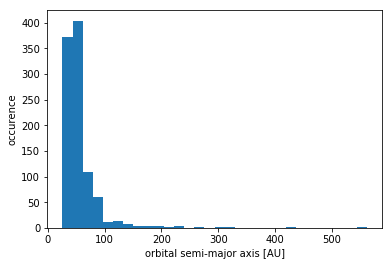

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

sma = [x[s.system.param_idx['sma1']] for x in orbits]

plt.hist(sma, bins=30)
plt.xlabel('orbital semi-major axis [AU]')
plt.ylabel('occurence')
plt.show()

You can use this method to create histograms of any orbital element you are interested in:

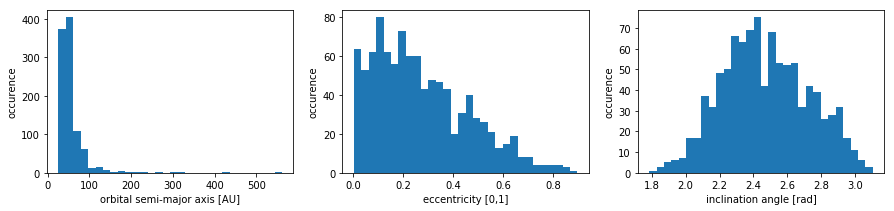

In [9]:
ecc = [x[s.system.param_idx['ecc1']] for x in orbits]
i = [x[s.system.param_idx['inc1']] for x in orbits]

plt.figure(figsize=(15,3))
plt.subplot(131)
plt.hist(sma, bins=30)
plt.xlabel('orbital semi-major axis [AU]')
plt.ylabel('occurence')

plt.subplot(132)
plt.hist(ecc, bins=30)
plt.xlabel('eccentricity [0,1]')
plt.ylabel('occurence')

plt.subplot(133)
plt.hist(i, bins=30)
plt.xlabel('inclination angle [rad]')
plt.ylabel('occurence')

plt.show()

### Corner Plot ###

In [10]:
import orbitize.results

In [11]:
myResults = orbitize.results.Results('OFTI',orbits)

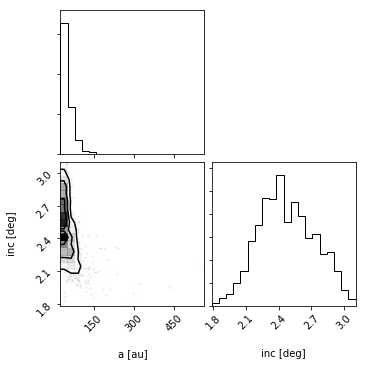

In [12]:
corner_figure = myResults.plot_corner(param_list=['sma1','inc1'])

### Orbit Plot ###

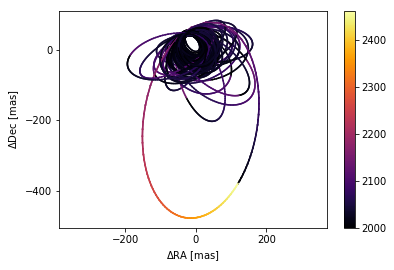

In [13]:
orbit_figure = myResults.plot_orbits()

## Advanced OFTI and API Interaction ##

1. prepare_samples
2. reject
3. run_sampler with default variables

Also demonstrate saving & loading results